# Analysis of the Dataset Extension Attack

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

In [53]:
# Load data
df = pd.read_csv("formatted_results_titanic.csv")

# Extract numeric dataset size (optional)
def extract_dataset_size(name):
    match = re.search(r"(\d+)k", name)
    if match:
        return int(match.group(1)) * 1000
    elif "euro" in name:
        return 25000  # placeholder
    return None

df["DatasetSize"] = df["Dataset"].apply(extract_dataset_size)
df["Overlap"] = df["Overlap"].astype(float)

# Output directory
os.makedirs("analysis/plots", exist_ok=True)
os.makedirs("analysis/tables", exist_ok=True)

# Metrics to visualize
metrics = [
    ("TrainedF1", "F1 Score"),
    ("ReidentificationRate", "Re-identification Rate"),
    ("TrainedRecall", "Recall"),
    ("TrainedPrecision", "Precision"),
    ("TotalRuntime", "Total Runtime (min)")
]

# Baseline metrics per dataset (dict format)
baseline_metrics = {
    "fakename_1k":     {"Precision": 0.2162, "Recall": 0.2476, "F1": 0.2300},
    "fakename_2k":     {"Precision": 0.2131, "Recall": 0.2452, "F1": 0.2271},
    "fakename_5k":     {"Precision": 0.2144, "Recall": 0.2470, "F1": 0.2287},
    "fakename_10k":    {"Precision": 0.2151, "Recall": 0.2467, "F1": 0.2289},
    "fakename_20k":    {"Precision": 0.2153, "Recall": 0.2473, "F1": 0.2293},
    "fakename_50k":    {"Precision": 0.2151, "Recall": 0.2463, "F1": 0.2288},
    "titanic_full":    {"Precision": 0.2468, "Recall": 0.3770, "F1": 0.2896},
    "euro_person":     {"Precision": 0.2197, "Recall": 0.2446, "F1": 0.2306}
}

In [54]:
# Loop through each (Encoding, Dataset) pair
for (encoding, dataset), group in df.groupby(["Encoding", "Dataset"]):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

    dataset_label = dataset.replace(".tsv", "").replace("_", " ")
    title = f"{encoding} — {dataset_label}"
    fig.suptitle(title, fontsize=16)

    dataset_key = dataset.replace(".tsv", "")

    # Regular metric plots
    for ax, (metric_key, metric_label) in zip(axes.flat[:6], metrics):
        sns.lineplot(
            data=group,
            x="Overlap",
            y=metric_key,
            hue="DropFrom",
            marker="o",
            ax=ax
        )
        ax.set_title(metric_label)
        ax.set_xlabel("Overlap")
        ax.grid(True)

        # Baselines
        if dataset_key in baseline_metrics:
            if metric_key == "TrainedF1":
                ax.axhline(y=baseline_metrics[dataset_key]["F1"], linestyle="--", color="gray", label="Baseline F1")
                ax.legend()
                ax.set_title("F1 & Dice Score")
            elif metric_key == "TrainedRecall":
                ax.axhline(y=baseline_metrics[dataset_key]["Recall"], linestyle="--", color="gray", label="Baseline Recall")
                ax.legend()
            elif metric_key == "TrainedPrecision":
                ax.axhline(y=baseline_metrics[dataset_key]["Precision"], linestyle="--", color="gray", label="Baseline Precision")
                ax.legend()

    # ➕ Updated: Two subplots for Re-ID Comparison by DropFrom
    melted = group.melt(
        id_vars=["Overlap", "DropFrom"],
        value_vars=["ReidentificationRateFuzzy", "ReidentificationRateGreedy", "ReidentificationRate"],
        var_name="Method",
        value_name="Rate"
    )
    method_map = {
        "ReidentificationRateFuzzy": "Fuzzy",
        "ReidentificationRateGreedy": "Greedy",
        "ReidentificationRate": "Combined"
    }
    melted["Method"] = melted["Method"].map(method_map)
    melted["Rate"] *= 100

    # Plot for DropFrom = Eve
    ax = axes.flat[5]
    subset_eve = melted[melted["DropFrom"] == "Eve"]
    sns.lineplot(
        data=subset_eve,
        x="Overlap",
        y="Rate",
        hue="Method",
        marker="o",
        ax=ax
    )
    ax.set_title("Re-ID (DropFrom = Eve)")
    ax.set_ylabel("Re-ID Rate (%)")
    ax.grid(True)

    # Plot for DropFrom = Both
    ax = axes.flat[6]
    subset_both = melted[melted["DropFrom"] == "Both"]
    sns.lineplot(
        data=subset_both,
        x="Overlap",
        y="Rate",
        hue="Method",
        marker="o",
        ax=ax
    )
    ax.set_title("Re-ID (DropFrom = Both)")
    ax.set_ylabel("Re-ID Rate (%)")
    ax.grid(True)

    # ➕ Subplot: Trained F1 vs. HypOp F1 (no DropFrom/Overlap)
    ax = axes.flat[7]
    sns.scatterplot(
        data=group,
        x="HypOpF1",
        y="TrainedF1",
        s=60,
        color="steelblue",
        ax=ax
    )
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="x = y")
    ax.set_title("Trained vs. HypOp F1")
    ax.set_xlabel("HypOp F1 (Validation)")
    ax.set_ylabel("Trained F1 (Full Data)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.legend(loc="lower right", fontsize="small")


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    filename = f"analysis/plots/{encoding}_{dataset_label.replace(' ', '_')}_metrics.png"
    plt.savefig(filename, dpi=300)
    plt.close()


In [55]:
# Select relevant columns for the summary
summary_df = df[[
    "Dataset", "Encoding", "Overlap", "DropFrom",
    "ReidentificationRateFuzzy", "ReidentificationRateGreedy", "ReidentificationRate"
]]

# Rename columns for clarity
summary_df = summary_df.rename(columns={
    "ReidentificationRateFuzzy": "Fuzzy Rate",
    "ReidentificationRateGreedy": "Greedy Rate",
    "ReidentificationRate": "Combined Rate"
})

# Sort for readability
summary_df = summary_df.sort_values(by=["Dataset", "Encoding", "Overlap", "DropFrom"])

# Export to CSV
summary_df.to_csv("analysis/tables/reidentification_summary.csv", index=False)

# Display as a table
summary_df.reset_index(drop=True, inplace=True)




In [56]:
# Ensure time columns are numeric
time_cols = [
    "GraphMatchingAttackTime", "HyperparameterOptimizationTime",
    "ModelTrainingTime", "ApplicationtoEncodedDataTime",
    "RefinementandReconstructionTime", "TotalRuntime"
]
df[time_cols] = df[time_cols].apply(pd.to_numeric, errors="coerce")

# 1. Overall Runtime Breakdown
avg_runtime = df[time_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_runtime.values, y=avg_runtime.index)
plt.title("Average Runtime Breakdown (All Experiments)")
plt.xlabel("Time in Minutes")
plt.tight_layout()
plt.savefig("analysis/plots/dea_runtime_overall.png", dpi=300)
plt.close()

# 3 . Runtime Breakdown: Average vs. Max
avg_times = df[time_cols].mean()
max_times = df[time_cols].max()
runtime_df = pd.DataFrame({
    "Average Time (m)": avg_times,
    "Max Time (m)": max_times
}).sort_values("Average Time (m)", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
runtime_df.plot(kind="barh", ax=plt.gca())
plt.title("DEA Runtime Breakdown: Average vs. Max")
plt.xlabel("Time (minutes)")
plt.ylabel("Pipeline Step")
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig("analysis/plots/dea_runtime_avg_vs_max.png", dpi=300)
plt.close()

# 2. Runtime by Encoding Scheme
encoding_runtime = df.groupby("Encoding")[time_cols].mean().T

encoding_runtime.plot(kind="bar", figsize=(12, 6))
plt.title("Average Runtime per Step by Encoding Scheme")
plt.ylabel("Time in Minutes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("analysis/plots/dea_runtime_by_encoding.png", dpi=300)
plt.close()

print("Saved runtime plots to analysis/plots/")


Saved runtime plots to analysis/plots/


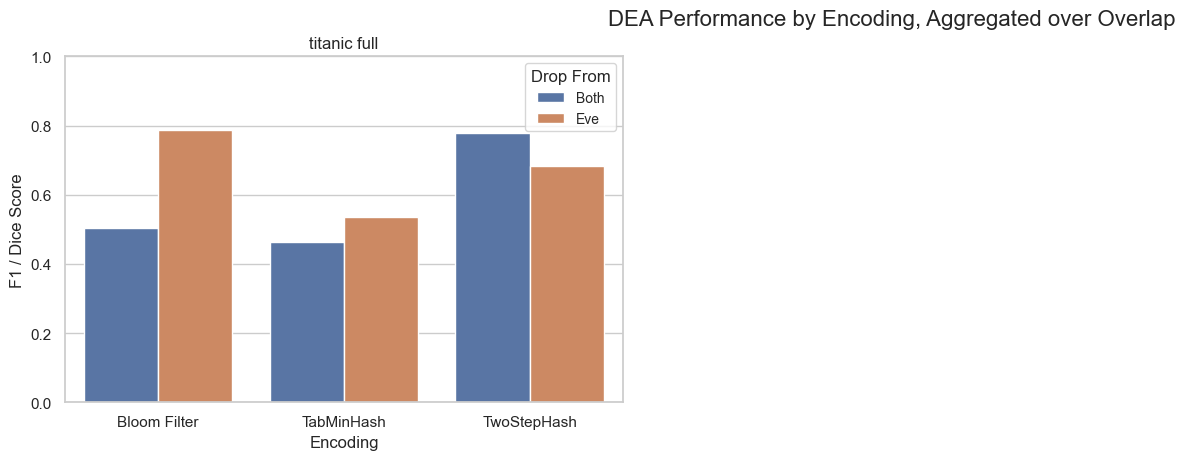

In [57]:
# Set consistent color palette and styling
sns.set(style="whitegrid")
encoding_map = {
    "BloomFilter": "Bloom Filter",
    "TabMinHash": "TabMinHash",
    "TwoStepHash": "TwoStepHash"
}
df["EncodingLabel"] = df["Encoding"].map(encoding_map)

# Get sorted list of datasets
datasets = sorted(df["Dataset"].unique())

# Create subplots: 3 columns, enough rows
n_cols = 3
n_rows = (len(datasets) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
axes = axes.flatten()

for i, dataset in enumerate(datasets):
    ax = axes[i]
    subset = df[df["Dataset"] == dataset]

    # Group by encoding and DropFrom, averaging across overlap
    grouped = (
        subset.groupby(["EncodingLabel", "DropFrom"])["TrainedF1"]
        .mean()
        .reset_index()
    )

    sns.barplot(
        data=grouped,
        x="EncodingLabel",
        y="TrainedF1",
        hue="DropFrom",
        ax=ax,
        errorbar="sd"
    )
    ax.set_title(dataset.replace(".tsv", "").replace("_", " "))
    ax.set_ylabel("F1 / Dice Score")
    ax.set_xlabel("Encoding")
    ax.set_ylim(0, 1)
    ax.legend(title="Drop From", loc="upper right", fontsize="small")

# Remove empty axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("DEA Performance by Encoding, Aggregated over Overlap", fontsize=16, y=1.02)
plt.savefig("dea_encoding_comparison_all_datasets.png", dpi=300, bbox_inches="tight")
plt.show()
